## CxC Data Hackathon - Infinite Investment Systems Ltd.

Wealth management platform customer churn prediction

### Import Libraries and Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, auc

from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import random

In [3]:
# we imported the dataset from our local since the file is too big for GitHub
train_data = pd.read_csv("./datasets/history.csv")
train_data.info()

C:\Users\srish\AppData\Local\Temp\ipykernel_5496\2566481893.py:1: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("./datasets/history.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673339 entries, 0 to 673338
Columns: 106 entries, id to label
dtypes: float64(21), int64(1), object(84)
memory usage: 544.5+ MB


### Data Exploration and Pre-Processing

#### Dropping Columns and Research

-  There are 106 columns (or 105 features) and 673339 entries in the data, with 67 columns containing null/NaN values. We split up these columns between the 4 teammates and for each feature, we investigated whether we should delete the missing rows, impute the values or disclude the feature from our analysis.
- We utilized the missing values heatmap plot shown in the CxC workshop to help us visually observe the columns that had a lot of missing values.

In [117]:
# Missing Values Check
def missing_values_check(df):
    missing_values = df.isnull().sum()
    value_counts = df.nunique()
    missing_values = pd.concat([missing_values, value_counts], axis=1)
    missing_values.columns = ['Missing Values', 'Value Counts']
    missing_values = missing_values[missing_values['Missing Values'] > 0]
    missing_values = missing_values.sort_values(by='Missing Values', ascending=False)
    return missing_values
    
missing_values_check_table = missing_values_check(train_data)
missing_values_check_table

,Missing Values,Value Counts
cashflows_custody_fee,673339,0
esir_number,673327,10
special_fee_code,673271,34
function_code,669102,23
country_code,669050,1
...,...,...
portfolio_name_address_option,3198,1
portfolio_report_option,3198,4
portfolio_summary_option,3198,1
inception_date,3198,5888


In [ ]:
# Missing Values Visualization (split into 4 parts)
# rotate the xtick label in heatmap

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
sns.heatmap(train_data.iloc[:, :28].isna(), cmap='Blues', ax=ax[0, 0])
sns.heatmap(train_data.iloc[:, 28:56].isna(), cmap='Blues', ax=ax[0, 1])
sns.heatmap(train_data.iloc[:, 56:82].isna(), cmap='Blues', ax=ax[1, 0])
sns.heatmap(train_data.iloc[:, 82:].isna(), cmap='Blues', ax=ax[1, 1])

# plt.xticks(rotation=90)

Columns 1-27:
- `rem_cols_na` - these columns have 600k+ NULL values, so it is better to drop them.
- `rem_cols_one_uniq` - these columns have no NULL values, but only one unique value which does not help in prediction. So, they can be dropped too.
- `null_3198_cols` - these columns all have exactly 3198 NULL values, characterized by when 'class_id' = NULL. They are probably related, so we can further investigate these together.

In [118]:
# Aditya Parekh - columns 1-27
rem_cols_na = ['country_code', 'cashflows_custody_fee', 'arp_pension_origin', 'sss_location']
rem_cols_one_uniq = ['net_of_fees', 'fee_paid_separately', 'custody_fee_withdrawal', 'is_fee_exempt']
null_3198_cols = ['debit_code', 'inception_date', 'branch', 'credit_limit_type', 'language_code', 'dividend_confirm_code']

Columns 28-55:
- `to_drop` - these columns either have too many NULL values or have only one unique value, making them not valuable to our prediction, and thus can be dropped.
- `missing_3198` - these columns all have 3198 NULL values, so they have been identified for further investigation with other such columns.

In [119]:
# Aditya Mani - columns 28-55
# 1. esir_number: Contains 673327 missing values and cannot be imputed (has very little unique values)
# 2. shareholder_language: Contains 623554 missing values. Says whether the shareholder speaks English or French and there seems to be an equal proportion.
# 3. has_no_min_commission: No Null values and only 1 unique value.
# 4. rep_commission_rate: 1 unique value and few missing values that cannot be imputed.
# 5. spousal_age_flag: No Null values and only 1 unique value.
# 6. is_parameters_account: No Null values and only 1 unique value.
# 7. rrsp_limit_reached: No Null values and only 1 unique value.
# 8. is_portfolio_account: No Null values and only 1 unique value.
# 9. sss_type: Lot of missing values
# 10. sss_agent: Lot of missing values
# 11. target_grantor_grantee_flag: Missing values
# 12. terminal_code: Missing values

to_drop = ['esir_number', 'shareholder_language', 'has_no_min_commission', 'rep_commission_rate',
           'spousal_age_flag', 'is_parameters_account', 'rrsp_limit_reached', 'is_portfolio_account',
             'sss_type', 'sss_agent', 'target_grantor_grantee_flag', 'terminal_code']

missing_3198 = ['options_trading_type',
 'is_midwest_clearing_account',
 'rep_commission_override',
 'interest_dividend_conversion_type',
 'guarantee_gtor_type',
 'deceased_fair_market_value',
 'iso_funds_code']

Columns 56-82:
- `drop_cols` - these columns have many NULL values that it is better to drop the features as there isn't enough info to impute and too many rows to delete. Column "last_update_date" is the maintaineance date and was deemed not relevant to the prediction of customer churn.
- `drop_uniq_cols` - these columns have only one unique value which is not useful prediction (and not possible to discern for imputation) and hence shall be dropped too.
- `nan_3198_cols` - these columns have exactly 3198 NULL values and can be investigated with the other columns with this same characteristic.


In [120]:
# Jithin Krishna - columns 56-82
drop_cols = ["special_tag", "conjunction", "title", "function_code" ,"tms_settlement_location", "loan_limit_override", "last_update_date"]
drop_uniq_cols = ["portfolio_cost_method", "portfolio_name_address_option", "portfolio_summary_option","interactive_portfolio_code"]
nan_3198_cols = ["portfolio_report_option", "mailing_consent"]

Columns 83-106:
- `too_many_nans` - these columns have more than 300k NULL/NaN values, with many unique values which would make imputation hard so they will be dropped.
- `nan_316985_columns` - these columns have exactly 316985 missing values so they may be connected; noted for further investigation.
- `only_one_unique` - these columns only have one unique valueso they are not adding valuable info for our analysis and prediction, thus can be dropped.

In [121]:
# Srishti Prayag - columns 83-106
too_many_nans = ['special_fee_code', 'resp_specimen_plan', 'plan_end_date', 'retail_last_maintenance_user']
nan_316985_columns = ['is_pledged', 'non_calendar_year_end', 'plan_effective_date', 'is_resp', 'number_of_beneficiaries', 'rrif_original_date', 'use_original_date_for_payment_calc', 'is_family_resp', 'is_hrdc_resp', 'retail_last_maintenance_time']
only_one_unique = ['is_plan_grandfathered', 'is_gl_account', 'is_control_account']

In [122]:
rem_cols = []
rem_cols.extend(rem_cols_na)
rem_cols.extend(rem_cols_one_uniq)
rem_cols.extend(to_drop)
rem_cols.extend(drop_cols)
rem_cols.extend(drop_uniq_cols)
rem_cols.extend(too_many_nans)
rem_cols.extend(only_one_unique)
train_data = train_data.drop(rem_cols, axis=1)

##### Further Investigation

`null_3198_cols`, `missing_3198`, `nan_3198_cols`
- These columns are all NULL for the same 3198 entries (which is a small number compared to the whole dataset) so we have decided to delete those rows.

In [123]:
all_3198_null_cols = []
all_3198_null_cols.extend(null_3198_cols)
all_3198_null_cols.extend(missing_3198)
all_3198_null_cols.extend(nan_3198_cols)

train_data[train_data['class_id'].isna()][all_3198_null_cols].isna().sum()

debit_code                           3198
inception_date                       3198
branch                               3198
credit_limit_type                    3198
language_code                        3198
dividend_confirm_code                3198
options_trading_type                 3198
is_midwest_clearing_account          3198
rep_commission_override              3198
interest_dividend_conversion_type    3198
guarantee_gtor_type                  3198
deceased_fair_market_value           3198
iso_funds_code                       3198
portfolio_report_option              3198
mailing_consent                      3198
dtype: int64

In [124]:
# Drop rows where column 'class_id' is NaN
train_data = train_data.dropna(subset=['class_id'])

#### Imputations & Deletions

- `is_arp_locked` - impute all NaN with 'f'; 
- `is_spousal`, `last_trade_date` - remove columns for insufficient data;
- `has_discrete_auth` - impute all NaN with 't'
- `contract_type` - remove rows where NaN
- `last_maintenance_time` -  remove rows where NaN
- `discretionary_trading_authorized` - impute all NaNs with 'n'.
- `type_code` - impute most frequent type_code
- `dup_trip_quad_code` drop column as it has only has one unique value and 12 missing values (insignificant)

- `retail_last_maintenance_time`, `non_calendar_year_end` - drop the columns
- `is_resp`, `is_hrdc_resp`, `retail_plan` - group by `type_code` and impute the NULL values with the mode of the group
- `is_family_resp` - if `type_code` is RESP and `number_of_beneficiaries` is greater than 1, then impute with 't' else 'f'
- `use_original_date_for_payment_calc` - if `type_code` is RESP then impute 't', else 'f'
- `rrif_original_date`, `plan_effective_date` - impute with `inception_date`(default)
- `number_of_beneficiaries` - impute with 0 (assuming no beneficiaries, which is also the mode)
- `is_pledged`, `non_plan_book_value` - impute with 'N' (default)

In [128]:
# Imputations/Deletions
def imputations(df):
    df['is_arp_locked'] = df['is_arp_locked'].fillna('f')
    df = df.drop(['is_spousal', 'last_trade_date', 'dup_trip_quad_code'], axis=1)
    df = df.dropna(subset=['contract_type'])
    df = df.dropna(subset=['last_maintenance_time'])
    df['has_discrete_auth'] = df['has_discrete_auth'].fillna('t')
    df['discretionary_trading_authorized'] = df['discretionary_trading_authorized'].fillna('n')
    df['type_code'] = df['type_code'].fillna(df['type_code'].mode()[0])
    df = df.drop(['retail_last_maintenance_time', 'non_calendar_year_end'], axis=1)
    df['is_resp'] = df.groupby('type_code')['is_resp'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'f'))
    df['is_hrdc_resp'] = df.groupby('type_code')['is_hrdc_resp'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'f'))
    df['is_family_resp'] = np.where((df['type_code'] == 'RESP') & (df['number_of_beneficiaries'] > 1), 't', 'f')
    df['retail_plan'] = df.groupby('type_code')['retail_plan'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'N/A'))
    df['use_original_date_for_payment_calc'] = np.where(df['type_code'] == 'RESP', 't', 'f')
    df['rrif_original_date'] = df['rrif_original_date'].fillna(df['inception_date'])
    df['number_of_beneficiaries'] = df['number_of_beneficiaries'].fillna(0.0)
    df['plan_effective_date'] = df['plan_effective_date'].fillna(df['inception_date'])
    df['is_pledged'] = df['is_pledged'].fillna('N')
    df['non_plan_book_value_flag'] = df['non_plan_book_value_flag'].fillna('N')
    return df

train_data = imputations(train_data)
train_data

,id,type_code,is_registered,currency_code,is_active,class_id,debit_code,contract_type,inception_date,branch,...,number_of_beneficiaries,rrif_original_date,use_original_date_for_payment_calc,is_family_resp,is_hrdc_resp,inserted_at,updated_at,is_olob,visible_in_reports,label
1,1268094,RRIF,t,CAD,t,5.0,C,18.0,2018-11-08,IAVM,...,0.0,2018-11-08,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,t,Churn
2,606613,SPOUSAL RRSP,t,CAD,t,5.0,A,16.0,2009-04-08,IAVM,...,0.0,2009-04-08,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,f,Churn
3,741930,CASH,f,CAD,t,3.0,T,12.0,2021-01-04,IAVM,...,0.0,2021-01-04,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,t,Churn
4,1137922,CASH,f,CAD,t,3.0,T,17.0,2017-07-21,IAVM,...,0.0,2017-07-21,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-08 20:52:08.352646+00,f,f,Churn
5,1020597,REG RRSP,t,CAD,t,5.0,C,9.0,2017-07-21,IAVM,...,0.0,2017-07-21,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,t,Churn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673333,574623,REG RRSP,t,CAD,t,5.0,C,9.0,2023-02-09,IAS,...,0.0,2023-02-09,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,t,Churn
673334,6827067,LIRA/LRSP/RLSP,t,CAD,t,5.0,C,18.0,2023-06-27,HOLIS,...,0.0,2023-06-27,f,f,f,2023-06-28 05:43:05.926802+00,2023-08-10 23:42:33.933152+00,f,t,Churn
673335,590659,REG RRSP,t,CAD,f,5.0,A,18.0,2006-11-23,IAVM,...,0.0,2006-11-23,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,f,No Churn
673336,1247774,CASH,f,CAD,t,3.0,T,16.0,2019-08-30,IAVM,...,0.0,2019-08-30,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,t,Churn


We can now confirm that all NULL values have been dealt with and we can move onto data engineering.

In [131]:
post_imputation_missing_table = missing_values_check(train_data)
post_imputation_missing_table

,Missing Values,Value Counts


#### Data Engineering

The "account_data_info" file specified that the `risk_tolerance` "indicates percentage of risk client wants to be within type of security, with the legend that Low = L, Medium = M, Medium-Higher = Q and High = H.
But, we found that there were also other letter codes B, C, D, G, S, X, etc. which we noticed were similar to the codes in the `investment_objective`.

Although we understand that all types of investement goals can accommodate different levels of risk tolerances, we used research and learned financial concepts to make educated classifications for each.
- Income = B, Safety = X - since such investors value current income via holding high-quality bonds, fixed-income and dividend-paying securities, they can be classified as generally being low risk tolerant, or very risk averse. So, we will classify 'B' and 'X' also as 'L' (low risk).
- Growth = C, Growth = G - since growth investors value future capital appreciation, they can be classified as being a little more risk tolerant (given the uncertainty of future payouts). So, we will classify 'C' and 'G' also as 'M' (medium risk).
- Speculative = D, Speculative = S - since "speculation investors seek maximum return...which generally involve a high level of risk," we will classify 'D' and 'S' also as 'H' (high risk).

Any other letters were classified as medium risk (as it is the mode).

Using the above mapping, we extracted the percentages of each level of risk and recorded it in 3 columns: `low_risk`, `medium_risk` and `high_risk`.
 
*Source: Wells Fargo https://www.wellsfargoadvisors.com/disclosures/guide-to-investing/investment-risk-tolerance.htm and course knowledge*

In [129]:
# Risk Tolerance Data Engineering
def extract_risk_tolerance(risk_tolerance):
    low_risk = 0
    medium_risk = 0
    high_risk = 0

    for i in range(0, len(risk_tolerance), 3):
        if risk_tolerance[i] in ['B', 'X', 'L']:
            low_risk += int(risk_tolerance[i+1:i+3])
        elif risk_tolerance[i] in ['G', 'C', 'M']:
            medium_risk += int(risk_tolerance[i+1:i+3])
        elif risk_tolerance[i] in ['S', 'D', 'H']:
            high_risk += int(risk_tolerance[i+1:i+3])
        else:
            medium_risk += int(risk_tolerance[i+1:i+3])

    return pd.Series({'low_risk': low_risk, 'medium_risk': medium_risk, 'high_risk': high_risk})

def risk_tolerance_impute(df):
    df['low_risk'] = 0
    df['medium_risk'] = 0
    df['high_risk'] = 0
    df['risk_tolerance'].fillna(df['risk_tolerance'].mode()[0], inplace=True)
    df['risk_tolerance'] = df['risk_tolerance'].astype(str)
    df[['low_risk', 'medium_risk', 'high_risk']] = df['risk_tolerance'].apply(extract_risk_tolerance)
    df = df.drop('risk_tolerance', axis=1)
    return df

train_data = risk_tolerance_impute(train_data)
train_data[['low_risk', 'medium_risk', 'high_risk']]

,low_risk,medium_risk,high_risk
1,0,90,10
2,0,50,50
3,0,99,0
4,0,99,0
5,20,70,10
...,...,...,...
673333,0,99,0
673334,0,99,0
673335,0,99,0
673336,0,75,25


The "account_data_info" file specified that the `investment_objective` has letters and percentages with the following legend: Income = B, Growth = C, Speculative = D, Growth = G, Liquidity = M, Speculative = S, Safety = X. Any other letters were classified as growth (as it is the mode).

Using the given mapping, we extracted and recorded into 5 columns: `income`, `growth`, `speculation`, `liquidity` and `safety`.

In [130]:
# Investment Objective Data Engineering
def extract_investment_obj(investment_objective):
    income = 0
    growth = 0
    speculation = 0
    liquidity = 0
    safety = 0

    for i in range(0, len(investment_objective), 3):
        if investment_objective[i] in ['B']:
            income += int(investment_objective[i+1:i+3])
        elif investment_objective[i] in ['G', 'C']:
            growth += int(investment_objective[i+1:i+3])
        elif investment_objective[i] in ['D', 'S']:
            speculation += int(investment_objective[i+1:i+3])
        elif investment_objective[i] in ['M']:
            liquidity += int(investment_objective[i+1:i+3])
        elif investment_objective[i] in ['X']:
            safety += int(investment_objective[i+1:i+3])
        else:
            growth += int(investment_objective[i+1:i+3])

    return pd.Series({'income': income, 'growth': growth, 'speculation': speculation, 'liquidity': liquidity, 'safety': safety})

def investment_objective_impute(df):
    df['income'] = 0
    df['growth'] = 0
    df['speculation'] = 0
    df['liquidity'] = 0
    df['safety'] = 0
    df['investment_objective'].fillna(df['investment_objective'].mode()[0], inplace=True)
    df['investment_objective'] = df['investment_objective'].astype(str)
    df[['income', 'growth', 'speculation', 'liquidity', 'safety']] = df['investment_objective'].apply(extract_investment_obj)
    df = df.drop('investment_objective', axis=1)
    return df

train_data = investment_objective_impute(train_data)
train_data[['income', 'growth', 'speculation', 'liquidity', 'safety']]

,income,growth,speculation,liquidity,safety
1,5,85,10,0,0
2,0,50,50,0,0
3,0,99,0,0,0
4,0,99,0,0,0
5,20,70,10,0,0
...,...,...,...,...,...
673333,0,99,0,0,0
673334,0,99,0,0,0
673335,0,99,0,0,0
673336,0,99,0,0,0


We will convert all dates in the table to number of months since that date (keeping 22 Feb, 2024 as the reference "today" date).
This will convert `rrif_original_date`, `plan_effective_date`, `inception_date` and `last_maintenance_time` to `rrif_months`, `plan_effective_months`, `inception_months` and `months_last_maintenance` respectively.

In [132]:
def convert_datetime(df):
    df['rrif_original_date'] = pd.to_datetime(df['rrif_original_date'])
    df['plan_effective_date'] = pd.to_datetime(df['plan_effective_date'])
    df['inception_date'] = pd.to_datetime(df['inception_date'])
    df['last_maintenance_time'] = pd.to_datetime(df['last_maintenance_time'])

    current_date = datetime(2024, 2, 22)

    # Calculate time difference in months from "today"'s date
    df['rrif_months'] = ((current_date - df['rrif_original_date']) / pd.Timedelta(days=30)).astype(int)
    df['plan_effective_months'] = ((current_date - df['plan_effective_date']) / pd.Timedelta(days=30)).astype(int)
    df['inception_months'] = ((current_date - df['inception_date']) / pd.Timedelta(days=30)).astype(int)
    df['months_last_maintenance'] = ((current_date - df['last_maintenance_time']) / pd.Timedelta(days=30)).astype(int)

    # Drop the original date columns
    df.drop(columns=['rrif_original_date', 'plan_effective_date', 'inception_date', 'last_maintenance_time'], inplace=True)
    return df

train_data = convert_datetime(train_data)
train_data[['rrif_months', 'plan_effective_months', 'inception_months', 'months_last_maintenance']]

,rrif_months,plan_effective_months,inception_months,months_last_maintenance
1,64,64,64,13
2,181,181,181,35
3,38,38,38,38
4,80,80,80,8
5,80,80,80,47
...,...,...,...,...
673333,12,12,12,12
673334,8,8,8,7
673335,210,210,210,50
673336,54,54,54,54


#### Encoding

We will encode all columns that have non-numerical values (which can be thought of as all the categorical variables). This way the models are able to easily work with the data. For most columns there are very few unique values compared to the number of instances (like 100 unique values vs ~600k instances). Because of this, lots of instances share the same value and and thus can be treated like they belong to that "category".

In [ ]:
# Use the OrdinalEncoder to convert labels into values
def encoder(df):
    ordinal_encoder = OrdinalEncoder()
    label_encoder = LabelEncoder()

    # Drop 'id' column from dataset as it is not needed for training the model
    to_encode = df.drop(columns=['id'], inplace=False)

    # Extract input features (X) and output labels (y)
    X = to_encode.drop(columns=['label'])  # Input features
    y = to_encode['label']  # Output labels

    # Identify categorical features to be encoded (excluding output label)
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    non_categorical_features = X.select_dtypes(exclude=['object']).columns.tolist()
    # Fit the encoder to the dataset and transform it
    X[categorical_features] = ordinal_encoder.fit_transform(X[categorical_features])

    # Normalize the non-categorical features using min-max scaling (df[column] - min(df[column])) / (max(df[column]) - min(df[column])
    scaler = MinMaxScaler()
    X[non_categorical_features] = scaler.fit_transform(X[non_categorical_features])

    encoded_array_y = label_encoder.fit_transform(y)
    y = pd.Series(encoded_array_y,name = "label")

    return X, y

X, y = encoder(train_data)
X

### Handling Data Imbalance

We can see that the data is quite significantly skewed as we have (after pre-processing) only about a 3:1 ratio of "Churn":"No Churn" entries in the training dataset.

/var/folders/gk/qw9z66_x6f568n5ry11rsp980000gn/T/ipykernel_66040/2655622597.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df.label, legend=True, palette='Set1')


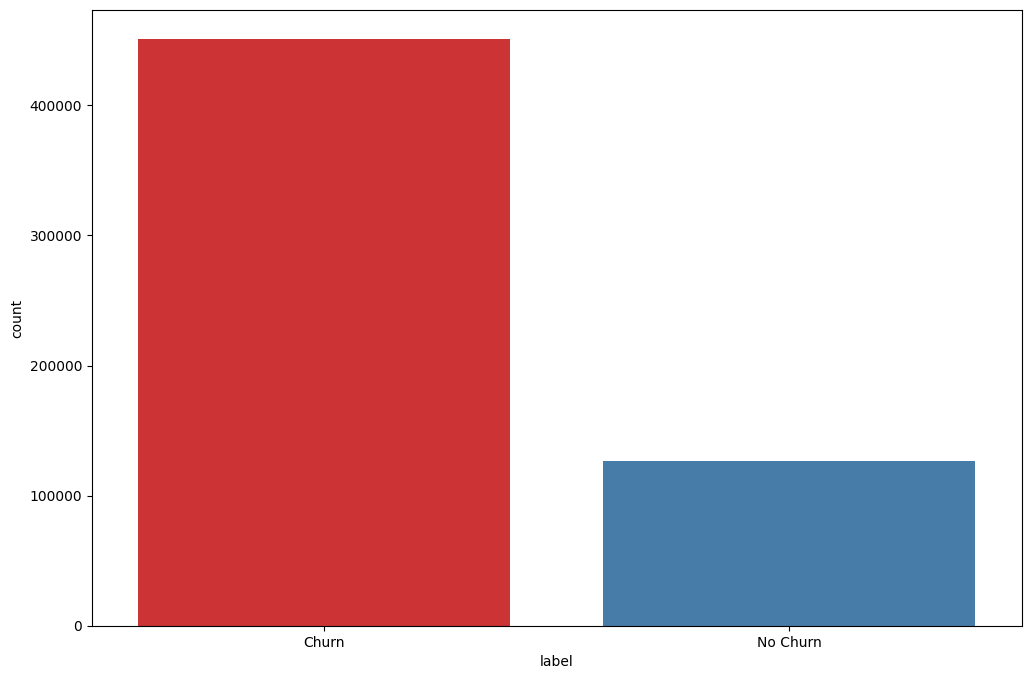

In [144]:
def churn_plot(df):
    plt.figure(figsize=(12,8))
    sns.countplot(x=df.label, legend=True, palette='Set1')

churn_plot(train_data)

We explored 2 sampling techniques to bridge the disparity between the number of instances and create a more balanced training dataset. This will give our models better data to train on and therefore a better chance at making reliable and accurate predictions.

#### Downsampling

Random downsampling is an undersampling method where we randomly remove some instances of the majority class (the "Churn" class in our case), so that we can achieve a more balanced distribution. We take all the "No Churn" data and randomly sample the same number of instances from the "Churn" data, saving this into a new table `downsample`.

In [ ]:
# Downsampling
random.seed(12345)
non_churn_size = sum(train_data["label"] == "No Churn")
non_churning_data = train_data[train_data["label"] == 'No Churn']
churning_data = train_data[train_data["label"] == "Churn"].sample(n= 1 * non_churn_size)
downsample = pd.concat([non_churning_data, churning_data])
x_down = downsample.drop(["label"], axis=1)
y_down = downsample["label"]

downsample

Although this is a simple approach to building a balanced dataset, there are some disadvantages:
- randomly sampling the majority class can significantly reduce the variability represented in the training data and therefore leading to inaccurate predictions
- reducing the sample size/training set size so significantly also reduces the efficiency of the model

So, we are going to consider a different approach that instead oversamples the data.

In [ ]:
churn_plot(pd.concat([x_down, y_down], axis=1))

#### Composite Sampling (SMOTE + Tomek Links)

This is combination of SMOTE and Tomek Link sampling.

SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic samples for the minority class ("No Churn") by finding k-nearest neighbours of a minority instance and interpolating a new synthetic instance from these.

Tomek Links sampling considers borderline or noisy samples and deletes such confusing instances from the majority class.

So with a combination of increasing minority instances and reducing borderline majority instances, we get a clearer dataset for the models.

In [138]:
# Handle class imbalance using SMOTETomek
smk = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=42, n_jobs=-1)
X_res, y_res = smk.fit_resample(X, y)
X_res

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:363: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


,type_code,is_registered,currency_code,is_active,class_id,debit_code,contract_type,branch,include_client_consolidation,use_client_address,...,high_risk,income,growth,speculation,liquidity,safety,rrif_months,plan_effective_months,inception_months,months_last_maintenance
0,14.0,1.0,0.0,1.0,0.054054,5.0,1.000000,5.000000,1.0,1.0,...,0.100000,0.050505,0.680000,0.100000,0.000000,0.0,0.133949,0.162465,0.162465,0.064815
1,17.0,1.0,0.0,1.0,0.054054,3.0,0.888889,5.000000,0.0,0.0,...,0.500000,0.000000,0.400000,0.500000,0.000000,0.0,0.404157,0.490196,0.490196,0.268519
2,0.0,0.0,0.0,1.0,0.027027,18.0,0.666667,5.000000,1.0,1.0,...,0.000000,0.000000,0.792000,0.000000,0.000000,0.0,0.073903,0.089636,0.089636,0.296296
3,0.0,0.0,0.0,1.0,0.027027,18.0,0.944444,5.000000,1.0,0.0,...,0.000000,0.000000,0.792000,0.000000,0.000000,0.0,0.170901,0.207283,0.207283,0.018519
4,12.0,1.0,0.0,1.0,0.054054,5.0,0.500000,5.000000,1.0,1.0,...,0.100000,0.202020,0.560000,0.100000,0.000000,0.0,0.170901,0.207283,0.207283,0.379630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899618,18.0,1.0,0.0,1.0,0.054054,3.0,0.719009,4.811567,1.0,0.0,...,0.300000,0.057101,0.560000,0.243470,0.000000,0.0,0.122902,0.149066,0.149066,0.000000
899619,16.0,1.0,0.0,1.0,0.054054,5.0,0.957360,5.000000,1.0,0.0,...,0.000000,0.232581,0.613936,0.000000,0.000000,0.0,0.160699,0.194910,0.194910,0.253450
899620,14.0,1.0,0.0,1.0,0.054054,3.0,1.000000,5.000000,1.0,0.0,...,0.000000,0.202020,0.640000,0.000000,0.000000,0.0,0.141037,0.171062,0.171062,0.092593
899621,12.0,1.0,0.0,1.0,0.054054,3.0,1.000000,5.000000,1.0,0.0,...,0.202062,0.105176,0.560000,0.195876,0.000000,0.0,0.137687,0.166999,0.166999,0.074456


/var/folders/gk/qw9z66_x6f568n5ry11rsp980000gn/T/ipykernel_66040/2655622597.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df.label, legend=True, palette='Set1')


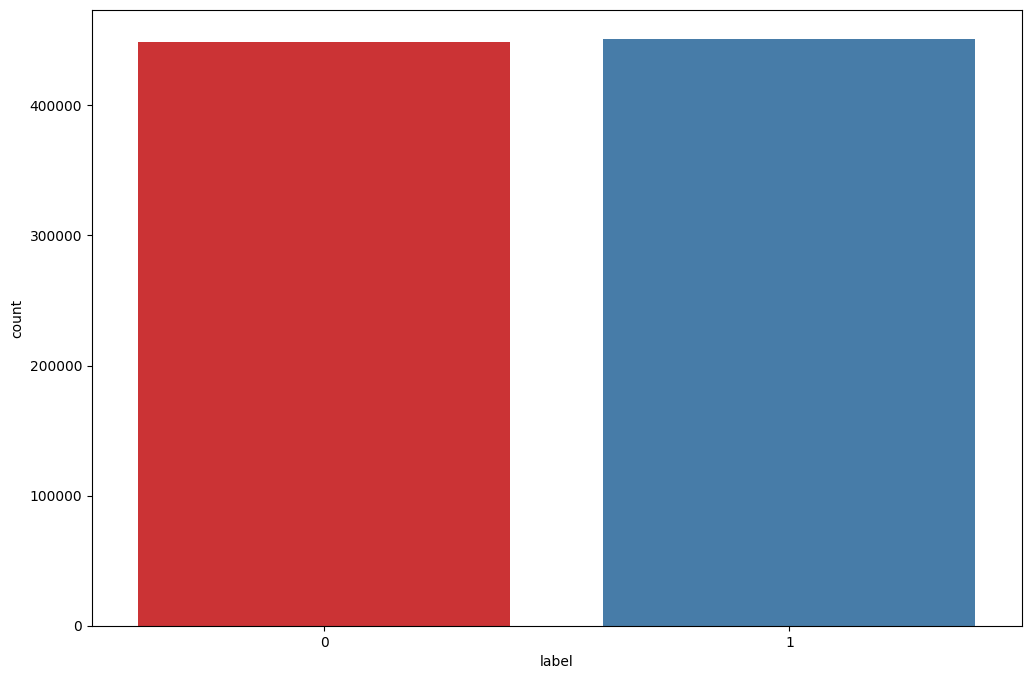

In [147]:
# Churn plot after smote tomek
# Note: 0 - Churn, 1 - No Churn
churn_plot(pd.concat([X_res, y_res], axis=1))

#### PCA

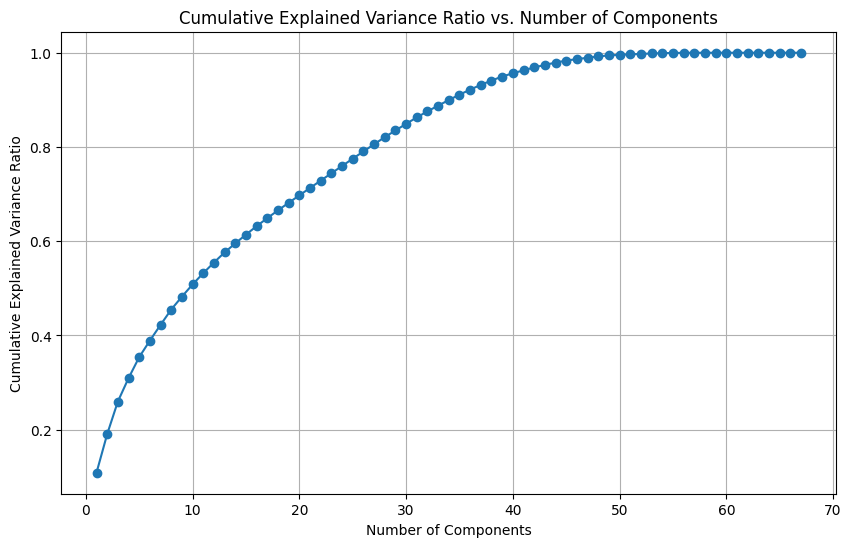

In [16]:
# Apply PCA to reduce the number of features
# to choose the number of components, we can use the elbow method
# Scale the features

# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# pca = PCA()
# pca.fit(X)
# explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance Ratio')
# plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
# plt.grid(True)
# plt.show()


In [17]:
# Deciding number of components = 35 from the plot
# components = 35
# pca = PCA(n_components=components)
# X_reduced = pca.fit_transform(X)
# X_reduced = pd.DataFrame(X_reduced, columns=[f"PC{i}" for i in range(1, components+1)])
# X_reduced.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,1.777792,-1.240415,-0.912904,-0.488181,0.105196,0.955698,-0.375790,0.949797,0.789163,0.518006,...,-0.038959,-0.251995,0.101923,0.719432,-0.214045,0.323010,-0.343081,0.130076,0.218641,-0.136897
1,1.861679,3.938993,-2.022556,3.469035,-1.127765,-1.235888,0.237150,-1.258917,-0.732949,-1.159718,...,-21.427719,12.027274,0.388064,-0.600847,3.408311,1.264378,-1.050022,1.174671,1.126307,-2.153115
2,-3.010849,-1.070977,0.608504,-2.462974,-0.553493,0.801734,-0.645187,0.836137,1.479403,0.227619,...,-0.002965,0.134432,-0.200110,-0.329114,0.269555,-0.498124,-0.036157,-0.316808,-0.236775,0.607848
3,-2.208205,-0.141353,0.606152,-1.681949,-0.840427,-1.191123,0.477054,-0.514608,-0.412665,-1.561154,...,-0.048337,-0.095568,0.308337,-0.383834,0.819308,0.871719,0.322216,-0.865830,-0.205895,0.396064
4,1.420960,-0.404551,-0.981984,0.170282,0.313441,1.530883,-0.698120,0.114195,0.444672,0.988019,...,-0.187357,-0.487105,-0.186718,0.738277,-1.253529,-0.231997,-0.209140,0.377670,-0.068915,0.065078


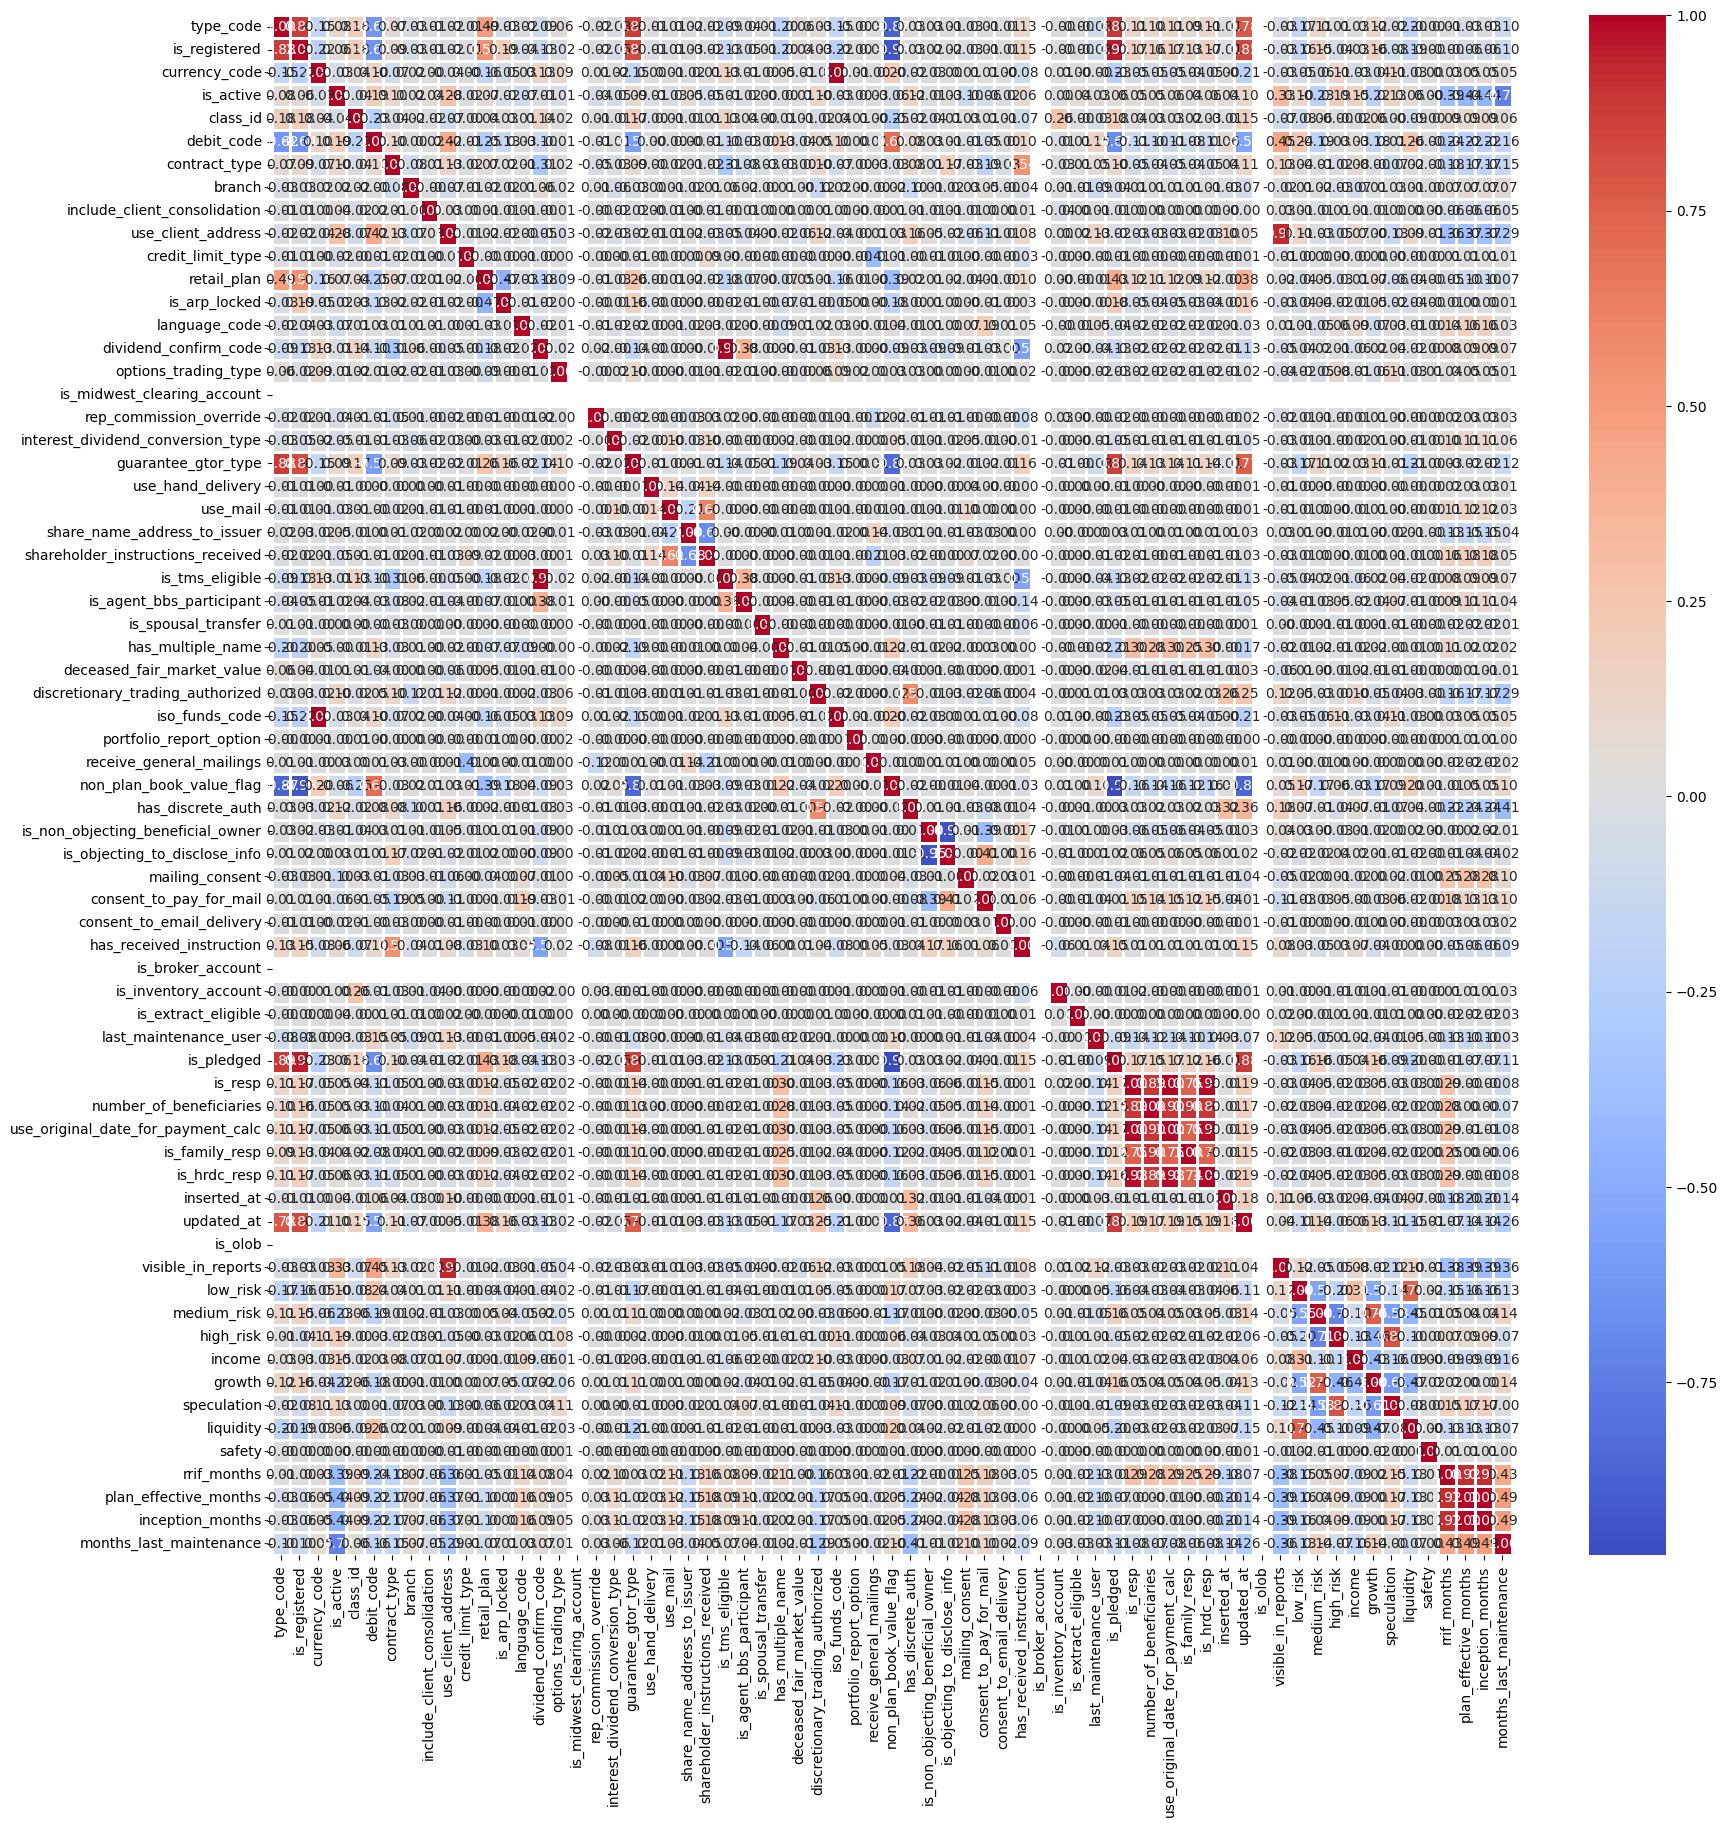

In [48]:
# Correlation Matrix
corr = X.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.show()

#### XGBoost

In [163]:
# XG_Boost function that also returns the trained model
def XG_Boost(X_param,y_param, feature_importance=False):
# Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_param, y_param, test_size=0.2, random_state=42)

    # Converting the data into DMatrix format, which is efficient for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

    # Defining parameters for XGBoost model with bagging (subsample < 1)
    params = {
        'objective': 'binary:logistic',  # binary classification problem
        'eval_metric': 'error',           # evaluation metric: classification error rate
        'subsample': 0.8,                  # fraction of training instances to be randomly sampled (bagging)
    }

    # Training the XGBoost model
    num_rounds = 100  # Number of boosting rounds
    bst = xgb.train(params, dtrain, num_rounds)

    # Making predictions on the testing set
    y_pred = bst.predict(dtest)
    y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

    # Evaluating the model
    accuracy = accuracy_score(y_test, y_pred_binary)
    print("Accuracy:", accuracy)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_binary))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_binary))

    if feature_importance == 1:
        # Get feature importance scores from the trained model
        feature_importance = bst.get_score(importance_type='weight')  # 'weight' represents the frequency of feature appearance in trees

        # Normalize feature importance scores to sum up to 1
        total_sum = sum(feature_importance.values())
        normalized_importance = {k: v / total_sum for k, v in feature_importance.items()}

        # Sort the feature importance dictionary by values (importance scores) in descending order
        sorted_importance = sorted(normalized_importance.items(), key=lambda x: x[1], reverse=True)

        # Print feature importance scores
        print("Feature Importance:")

        # Plot the feature importance scores
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
        plt.xticks(range(len(sorted_importance)), [val[0] for val in sorted_importance], rotation=90)
        plt.xlabel('Feature')
        plt.ylabel('Importance Score')
        plt.title('Feature Importance Scores')
        plt.show()

    return bst

In [165]:
# XG Boost on imbalanced data:
bst_original = XG_Boost(X, y)

Accuracy: 0.9647159696179729

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     90359
           1       0.86      1.00      0.92     25104

    accuracy                           0.96    115463
   macro avg       0.93      0.98      0.95    115463
weighted avg       0.97      0.96      0.97    115463


Confusion Matrix:
[[86323  4036]
 [   38 25066]]


Accuracy: 0.9804863137418369

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     89618
           1       0.96      1.00      0.98     90307

    accuracy                           0.98    179925
   macro avg       0.98      0.98      0.98    179925
weighted avg       0.98      0.98      0.98    179925


Confusion Matrix:
[[86138  3480]
 [   31 90276]]
Feature Importance:


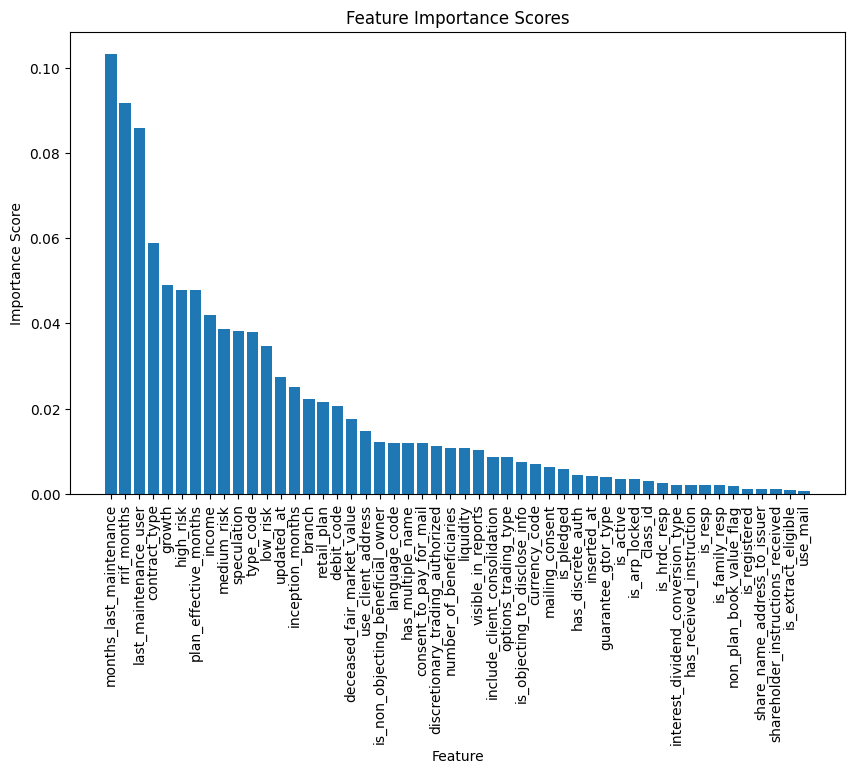

In [168]:
# XG Boost on balanced data:
bst_smote = XG_Boost(X_res, y_res, True)

#### Random Forest

In [76]:
# Random Forest
rf = RandomForestClassifier(random_state = 42)
cv = cross_val_score(rf,X_res.values,y_res.values,cv=5)
print("5-fold CV Scores:", cv)
print("5-fold Avg CV Score:", cv.mean())

5-fold CV Scores: [0.96939818 0.97691949 0.98022464 0.98043017 0.98053571]
5-fold Avg CV Score: 0.9775016386886047


In [78]:
# Train Random Forest Model
X_array = X_res.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y_res.values, test_size=0.8, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [79]:
# Random Forest Metrics

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print(f"F1 Score: {f1}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9782012753996734
F1 Score: 0.9786191312259845

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    359355
           1       0.96      1.00      0.98    360733

    accuracy                           0.98    720088
   macro avg       0.98      0.98      0.98    720088
weighted avg       0.98      0.98      0.98    720088


Confusion Matrix:
[[345159  14196]
 [  1501 359232]]
